In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX', 'TSLA']:
#     if symbol == 'VRTX':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2008-06-02'
start_date = '2017-01-03'
# start_date = '2018-01-01'
end_date = '2018-06-06'

### Turtle
TURTLE_POS = 10
TURTLE_BUY_N = 60
TURTLE_SELL_N = 60

### 业务设置
is_happy_money = False
START_MONEY = 10000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY

Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
    stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
    stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
    stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
    stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
    stock_df['N'] = stock_df['TR'].rolling(20).mean()
    stock_df['Unit'] = (0.01 * START_MONEY) / (stock_df['N'])
    stock_df['rolling_%d_max' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).max()
    stock_df['rolling_%d_min' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).min()
    stock_df['rolling_max'] = stock_df['open'].rolling(TURTLE_BUY_N).max()
    stock_df['rolling_min'] = stock_df['open'].rolling(TURTLE_SELL_N).min()
    stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
    stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 50.3 s


In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [15, 10]

# # stock_df_dict.keys()
# # stock_df_dict['TSLA']

# df = stock_df_dict['TSLA']
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# df = df.loc[:, ['open', 'rolling_60_max', 'rolling_30_min', 'MA60', 'MA30']]

# # display_charts(df, kind='line', figsize=(900, 600), logy=False)
# # ax = df.plot(kind='line', label='NDX', linewidth=0.5)

# for symbol in NASDAQ100:
#     tdf = stock_df_dict[symbol].loc['2018-06-07':]
#     tdf = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol].rolling_60_max)]
#     if len(tdf) == 0:
#         continue
#     symbol
#     tdf

In [6]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 502 µs


In [16]:
%%time
# %xmode


PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None

# rolling_min_dict = {}
# rolling_max_dict = {}

# for symbol in NASDAQ100:
#     rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
#     rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    # 买卖过程
    for symbol in NASDAQ100:
#     for symbol in ['TSLA']:
        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
        is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
        # 突破上行趋势，从未建仓或已清仓，建仓1Unit
        if not is_has_order or (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0):
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
            if is_buy:
#                 buy_count = min(
#                     int(stock_df_dict[symbol].shift(1).loc[today, 'Unit']),
#                     int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#                 )
#                 print(symbol, today)
                buy_count = int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
                if buy_count > int(CASH / stock_df_dict[symbol].loc[today, 'open']):
                    buy_count = 0
                if buy_count > 0:
                    CASH -= buy_count * stock_df_dict[symbol].loc[today, 'open']
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                            'buy_reason': 'ENTER',
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
            
        # 升幅大于0.5N，加仓1Unit
        if is_has_order and not (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0):
            is_buy = (
                stock_df_dict[symbol].loc[today, 'open'] > \
                order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + \
                0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N']
            )
            if is_buy:
#                 buy_count = min(
#                     int(stock_df_dict[symbol].shift(1).loc[today, 'Unit']),
#                     int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#                 )
                buy_count = int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
                if buy_count > int(CASH / stock_df_dict[symbol].loc[today, 'open']):
                    buy_count = 0
                if buy_count > 0:
                    CASH -= buy_count * stock_df_dict[symbol].loc[today, 'open']
#                     print(today, '加仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                            'buy_reason': 'ADD',
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
        
        # 降幅大于2N，清仓退出
        if is_has_order and not (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0):
            is_sell = (
                stock_df_dict[symbol].loc[today, 'open'] < \
                order_df[order_df['symbol'] == symbol].buy_price.iloc[-1] - 2 * stock_df_dict[symbol].shift(1).loc[today, 'N']
            )
            if is_sell:
                for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                    CASH += order_df.loc[idx, 'buy_count'] * stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_reason'] = 'LOSS'
                    order_df.loc[idx, 'profit'] = \
                        (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
#                 print(today, '止损', stock_df_dict[symbol].loc[today, 'open'], CASH)
        
        # 突破下行趋势，清仓退出
        if is_has_order and not (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0):
            is_sell = (stock_df_dict[symbol].loc[today, 'open'] <= stock_df_dict[symbol].loc[today, 'rolling_min'])
            if is_sell:
                for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                    CASH += order_df.loc[idx, 'buy_count'] * stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
    
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'].iloc[-1].open
print('NDX', s_p, e_p, e_p / s_p)


1777.32
0
13236.57
NDX 4900.854 7212.431 1.47166820313
Wall time: 2min 1s


In [14]:
# 165 * 220
# 25197.25 / 228.97

# buy_count = min(
#                     int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit']),
#                     int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
#                 )
# int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit'])
# int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
# buy_count

# pd.reset_option("display.max_rows")
# order_df

# order_df[(order_df['symbol'] == 'TSLA') & (order_df['sell_price'] == 0)]
# pd.options.display.max_rows = 999
# stock_df_dict['TSLA'].loc[start_date:]

In [17]:
'ALL'
'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** 0.1

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
calc_df

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

'ALL'

('len(order_df)', 13)

('sum_profit', -1714.3199999999988)

('sum_tax', 0)

('win rate', 0.09090909090909091)

('REWARD', 0.98137008579609275)

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property,profit_pct
0,2017-01-04,FOXA,120,28.88,ENTER,2017-05-04,28.8,LOSS,-9.6,6534.40,10000,-0.00277008
1,2017-01-05,DISH,76,60.22,ENTER,2017-04-18,57.66,EXIT,-194.56,1957.68,10000,-0.0425108
2,2017-04-18,FOXA,187,30.68,ADD,2017-05-04,28.8,LOSS,-351.56,602.68,10378.5,-0.0612777
3,2017-05-04,ULTA,25,290.01,ENTER,2017-07-06,276.51,LOSS,-337.5,2194.03,9966.18,-0.0465501
4,2017-07-07,AAL,81,52.30,ENTER,2017-07-26,50.63,LOSS,-135.27,4870.48,9106.78,-0.0319312
5,2017-07-10,AAL,82,52.98,ADD,2017-07-26,50.63,LOSS,-192.7,526.12,9106.78,-0.0443564
6,2017-07-26,BKNG,3,2019.24,ENTER,2017-08-09,1910.51,LOSS,-326.19,2721.09,8920.62,-0.053847
7,2017-08-10,ALGN,23,174.92,ENTER,NaT,0,NaN,0,4429.46,8452.62,0
8,2017-08-10,BIDU,16,227.50,ENTER,2017-08-29,216,LOSS,-184,789.46,8452.62,-0.0505495
9,2017-08-30,TTWO,38,96.11,ENTER,2018-03-20,105.34,EXIT,350.74,593.28,8225.15,0.0960358


In [11]:
# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.loc[start_date:end_date, 'close']
# #     print(df)
#     s_p = df.head(1).values
#     e_p = df.tail(1).values
# #     print(symbol, s_p, e_p, e_p / s_p)


In [12]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = order_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 500)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

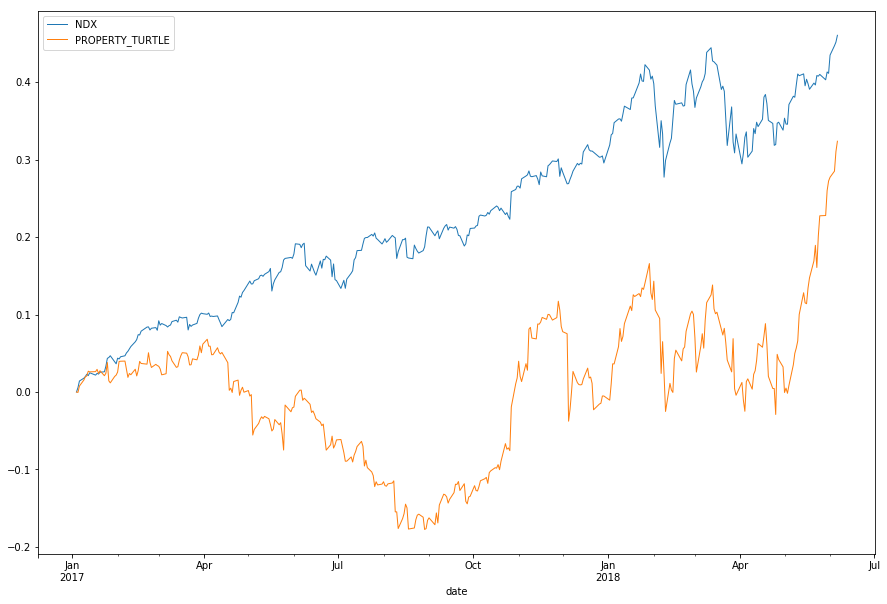

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_TURTLE'] = (df['PROPERTY_TURTLE'] - df.iloc[0]['PROPERTY_TURTLE']) / df.iloc[0]['PROPERTY_TURTLE']
# df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.iloc[0]['PROPERTY_T+B']) / df.iloc[0]['PROPERTY_T+B']

ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY_TURTLE', secondary_y=False, label='PROPERTY_TURTLE', linewidth=1, ax=ax)
# ax = df.plot(kind='line', y='PROPERTY_T+B', secondary_y=False, label='PROPERTY_T+B', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()

# df = df.loc[:, ['close', 'PROPERTY_TURTLE', 'PROPERTY_T+B']]
# df
# display_charts(df, kind='line', figsize=(900, 600), logy=False)